In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import random

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
from plstm_cell import PLSTM

In [3]:
X_train = np.load('PLSTM_train_input.npy')
X_test = np.load('PLSTM_test_input.npy')
X_val = np.load('PLSTM_val_input.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')
y_val = np.load('y_val.npy')

In [4]:
t_train1 = np.load('PLSTM_t_train_in.npy')
t_test1 = np.load('PLSTM_t_test_in.npy')
t_val1 = np.load('PLSTM_t_val_in.npy')

In [5]:
print(f'x_train, x_val, x_test shapes: {X_train.shape}, {X_val.shape}, {X_test.shape}')
print(f'y_train, y_val, y_test shapes: {y_train.shape}, {y_val.shape}, {y_test.shape}')

x_train, x_val, x_test shapes: (406453, 100, 6), (135485, 100, 6), (232260, 100, 6)
y_train, y_val, y_test shapes: (406453, 2, 2), (135485, 2, 2), (232260, 2, 2)


In [6]:
# import into torch
batch_size = 256

train_features = torch.from_numpy(X_train).float()
train_targets = torch.from_numpy(y_train).float()
val_features = torch.from_numpy(X_val).float()
val_targets = torch.from_numpy(y_val).float()
test_features = torch.from_numpy(X_test).float()
test_targets = torch.from_numpy(y_test).float()

t_train1 = torch.from_numpy(t_train1).float()
t_val1 = torch.from_numpy(t_val1).float()
t_test1 = torch.from_numpy(t_test1).float()
print(t_train1.size())

torch.Size([406453, 100])


In [7]:
train = TensorDataset(train_features, train_targets, t_train1)
val = TensorDataset(val_features, val_targets, t_val1)
test = TensorDataset(test_features, test_targets, t_test1)

train_loader = DataLoader(train, batch_size=batch_size)
val_loader = DataLoader(val, batch_size=batch_size)
test_loader = DataLoader(test, batch_size=batch_size)

In [14]:
class Net(nn.Module):
    # constructor
    def __init__(self, layers):
        super(Net, self).__init__()
        # plstm layer
        self.input_size = layers[0] 
        self.hidden_size1 = layers[1]
        self.hidden_size2 = layers[2]


        # concantenate layer
        self.conc = layers[1] + 2

        
        self.output_size = layers[3]
        # hidden layer
        self.PLSTM = PLSTM(self.input_size, self.hidden_size1)

        self.LSTM  = nn.LSTM(self.conc, self.hidden_size2, batch_first=True)
        # output layer
        self.output = nn.Linear(self.hidden_size2, self.output_size)

    # predict
    def forward(self, x, t):
        # x is in the shape of (batch size, sequence length, input_variables)
        # print("x dimensions before slicing:", x.shape)
        state = torch.cat((x[:, :, 0:2], x[:, :, 4:]), dim=2)
        # print("State dimensions after slicing:", state.shape)
        u = x[:, :, 2:4]
        self.hidden_seq, ht, kt = self.PLSTM(state, t)
        self.shift= kt[0]
        self.period = kt[1]
        self.on_mid = kt[2]
        self.on_end = kt[3]

        plstm_out = (self.hidden_seq)
        # print("PLSTM output dimensions:", plstm_out.shape)
        # concantenate
        combined = torch.cat((plstm_out, u), dim=2)
        # print("Combined dimensions:", combined.shape)

        lstm_out, _ = self.LSTM(combined)
        # print("LSTM output dimensions:", lstm_out.shape)

        
        out = self.output(lstm_out)

        # Extract the last 50 time steps
        out = out[:,-2:,:] # shape: [batch size, sequence length, input_variables]



        return out

In [10]:
def train(model, epochs, optimizer, criterion, trainloader, val_loader):
    TRAIN_LOSS = []
    VAL_LOSS = []
    shift_change = []
    period_change = []
    on_mid_change = []
    on_end_change = []

    for epoch in range(epochs):
        start_time = time.time()
        BATCH_LOSS = []
        for x, y, t in trainloader:
            optimizer.zero_grad()
            yhat = model(x, t)
            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()
            BATCH_LOSS.append(loss.cpu().item())
        training_loss = np.mean(BATCH_LOSS)
        TRAIN_LOSS.append(training_loss)

        # validation
        with torch.no_grad(): #disable gradient calculation
            # set model to eval mode
            model.eval()
            val_loss = 0.0
            BATCH_VAL_LOSS = []
            for x_val, y_val, t_val in val_loader:
                ypred = model(x_val, t_val)
                loss_val = criterion(ypred, y_val)
                BATCH_VAL_LOSS.append(loss_val.cpu())
                val_loss += loss_val.cpu().item()

        val_loss /= len(val_loader)
        validation_loss = np.mean(BATCH_VAL_LOSS)
        VAL_LOSS.append(validation_loss)

        shift_change.append(model.shift.cpu().detach().numpy())
        period_change.append(model.period.cpu().detach().numpy())
        on_mid_change.append(model.on_mid.cpu().detach().numpy())
        on_end_change.append(model.on_end.cpu().detach().numpy())
        end_time = time.time()
        time_taken = end_time - start_time
        print(f'Epoch {epoch+1}/{epochs}, {time_taken:.4f}s, loss = {training_loss: .5e}, val_loss = {validation_loss:.5e}, shift: {model.shift.cpu().detach().numpy()[0][0]}')
    return TRAIN_LOSS, VAL_LOSS, shift_change, period_change, on_mid_change, on_end_change

In [18]:
def test_eval(model, criterion, testloader):
    with torch.no_grad(): #disable gradient calculation
    # set model to et mode
        model.eval()

        BATCH_t_LOSS = []
        for x_t, y_t, t_t in testloader:
            ypredt = model(x_t, t_t)
            y_actual = y_t
            loss_t = criterion(ypredt, y_actual)
            # print(loss_t)
            # break
            BATCH_t_LOSS.append(loss_t.cpu())
    testing_loss = np.mean(BATCH_t_LOSS)
    return testing_loss

In [28]:
torch.manual_seed(123)
layers = [4, 24, 8, 2]
model = Net(layers)
optimizer = optim.Adam(model.parameters(), lr = 0.001) #default lr
criterion = nn.MSELoss()
model.parameters

<bound method Module.parameters of Net(
  (PLSTM): PLSTM()
  (LSTM): LSTM(26, 8, batch_first=True)
  (output): Linear(in_features=8, out_features=2, bias=True)
)>

In [29]:
TRAIN_LOSS, VAL_LOSS, shift_change, period_change, on_mid_change, on_end_change= train(model=model, epochs=100, optimizer=optimizer, criterion=criterion, trainloader=train_loader, val_loader=val_loader)

Epoch 1/100, 432.7019s, loss =  1.92821e-01, val_loss = 1.24161e-01, shift: 16.927356719970703
Epoch 2/100, 427.4553s, loss =  1.22798e-01, val_loss = 1.21253e-01, shift: 16.931133270263672
Epoch 3/100, 421.6727s, loss =  1.20891e-01, val_loss = 1.20292e-01, shift: 16.934659957885742
Epoch 4/100, 420.0161s, loss =  1.20600e-01, val_loss = 1.20117e-01, shift: 16.94052505493164
Epoch 5/100, 419.1523s, loss =  1.20085e-01, val_loss = 1.19154e-01, shift: 16.974794387817383
Epoch 6/100, 419.1256s, loss =  9.29586e-02, val_loss = 7.26976e-02, shift: 16.978412628173828
Epoch 7/100, 419.6629s, loss =  5.60678e-02, val_loss = 4.48102e-02, shift: 16.9647216796875
Epoch 8/100, 418.7201s, loss =  4.32700e-02, val_loss = 4.23253e-02, shift: 16.96901512145996
Epoch 9/100, 418.5853s, loss =  4.19303e-02, val_loss = 4.14894e-02, shift: 16.981149673461914
Epoch 10/100, 418.8265s, loss =  4.13705e-02, val_loss = 4.10303e-02, shift: 16.985061645507812
Epoch 11/100, 418.5387s, loss =  4.09540e-02, val_los

In [30]:
print(test_eval(model, criterion=criterion, testloader=test_loader))

0.024437044


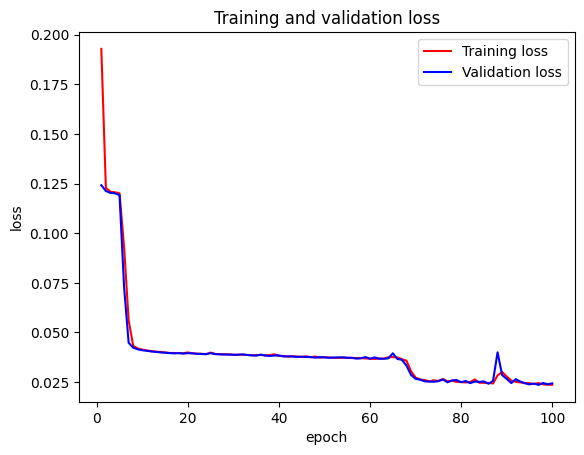

In [31]:
length = len(TRAIN_LOSS)
epochs = range(1, length+1)
plt.plot(epochs, TRAIN_LOSS, 'r', label='Training loss')
plt.plot(epochs, VAL_LOSS, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [38]:
input_mean = np.array([-2.13124010e-03, -6.78121852e+01, -5.90934756e-04,  1.30549989e+02,
 -8.84170431e-03,  6.76110004e-01,  5.05000000e+01])
input_std = np.array([2.85780447e+00, 4.08214102e+05, 2.85777554e+00, 4.08177358e+05,
 8.49529132e-01, 4.30228811e+01, 2.88660700e+01])

output_mean = np.array([-0.05992626,  3.19450381])
output_std = np.array([0.87320381, 57.35956821])

In [40]:
save_path = 'PLSTM.pth'
torch.save(model.state_dict(), save_path)